In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df_clean = pd.read_csv("Clean-Data")
df_clean

,timestamp,fridge,ac,lights,microwave,total_power
0,2023-01-01 00:00:00,78,0,85,0,163.0
1,2023-01-01 01:00:00,81,0,30,0,111.0
2,2023-01-01 02:00:00,68,0,76,0,144.0
3,2023-01-01 03:00:00,57,1612,69,919,2657.0
4,2023-01-01 04:00:00,150,0,85,0,235.0
...,...,...,...,...,...,...
4316,2023-06-29 20:00:00,194,1193,95,0,1482.0
4317,2023-06-29 21:00:00,0,1715,46,0,1761.0
4318,2023-06-29 22:00:00,92,0,50,0,142.0
4319,2023-06-29 23:00:00,0,1426,27,0,1453.0


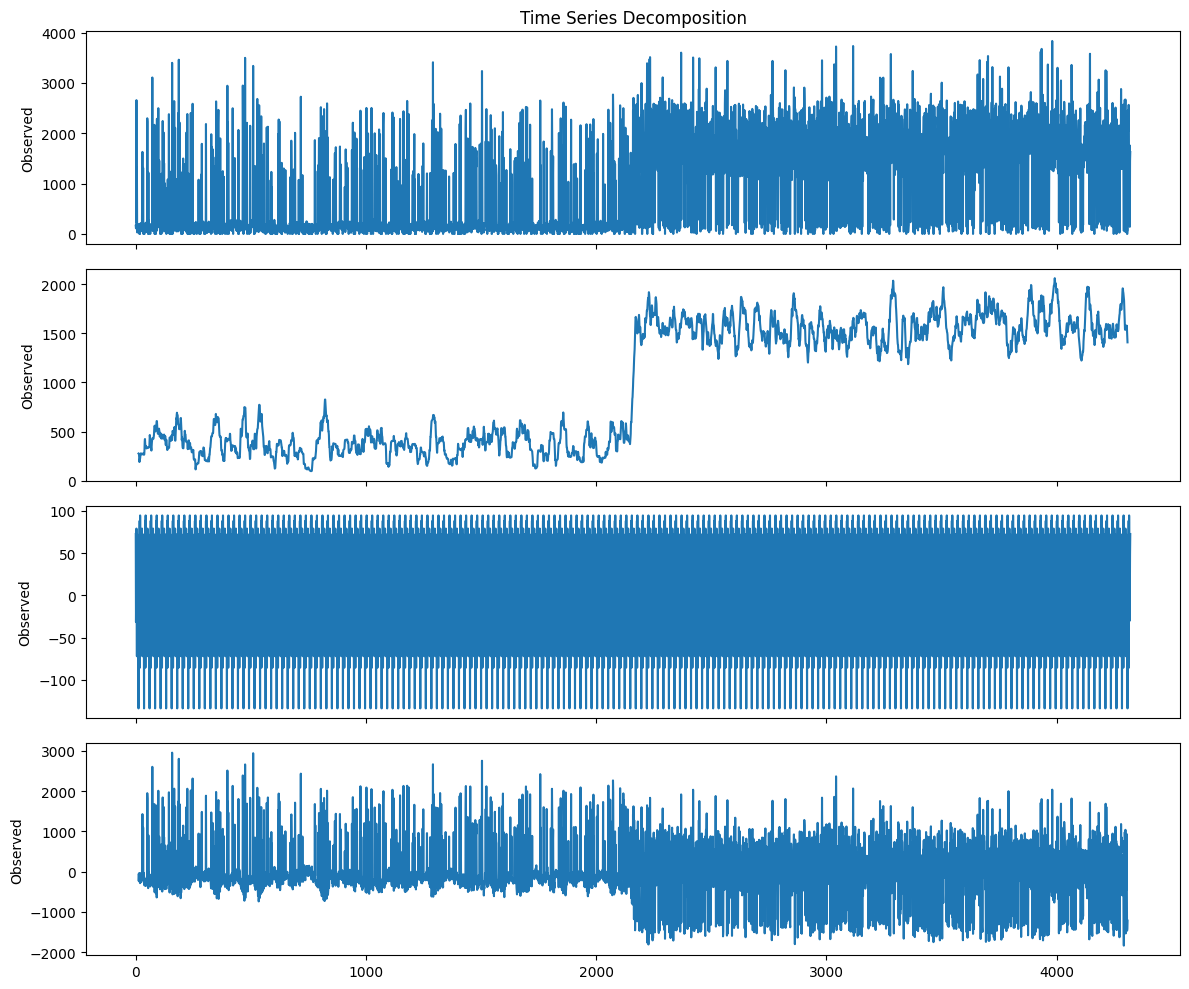

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

target_col = df_clean['total_power']

# Y(t) = Trend(t) + Seasonality(t) + Residual(t)
decomposition = seasonal_decompose(df_clean['total_power'], model = 'additive', period = 24)

decomposition

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(12,10),sharex=True)

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")
ax1.set_title("Time Series Decomposition")

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel("Observed")
# ax1.set_title("Time Series Decomposition")

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel("Observed")
# ax1.set_title("Time Series Decomposition")

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel("Observed")
# ax1.set_title("Time Series Decomposition")

plt.tight_layout()
plt.show()


In [12]:
import os

# Construct path to data
base_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(base_dir, 'data', 'raw', 'energy_data.csv')

# Check if running from notebook dir or project root
if not os.path.exists(data_path):
    # Fallback for direct path if needed
    data_path = r'c:\Users\SRIDHAR RAO\OneDrive\Desktop\1711\energy_consumption_project\data\raw\energy_data.csv'

print(f"Loading data from: {data_path}")
df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

print("Data loaded successfully. Shape:", df.shape)
df.head()
df

Loading data from: c:\Users\SRIDHAR RAO\OneDrive\Desktop\1711\energy_consumption_project\data\raw\energy_data.csv
Data loaded successfully. Shape: (4321, 5)


,fridge,ac,lights,microwave,total_power
timestamp,,,,,
2023-01-01 00:00:00,119,0,59,0,178
2023-01-01 01:00:00,119,0,20,0,139
2023-01-01 02:00:00,0,0,78,0,78
2023-01-01 03:00:00,68,0,87,0,155
2023-01-01 04:00:00,162,0,61,0,223
...,...,...,...,...,...
2023-06-29 20:00:00,76,2272,98,0,2446
2023-06-29 21:00:00,67,1065,38,0,1170
2023-06-29 22:00:00,0,1383,22,0,1405


In [16]:
target_col = 'total_power'

skewness =  df[target_col].skew()
kurtosis = df[target_col].kurtosis()

print(f"skewness of {target_col}: {skewness:.4f}")
print(f"kurtosis of {target_col}: {kurtosis:.4f}")

skewness of total_power: 0.5076
kurtosis of total_power: -1.0878


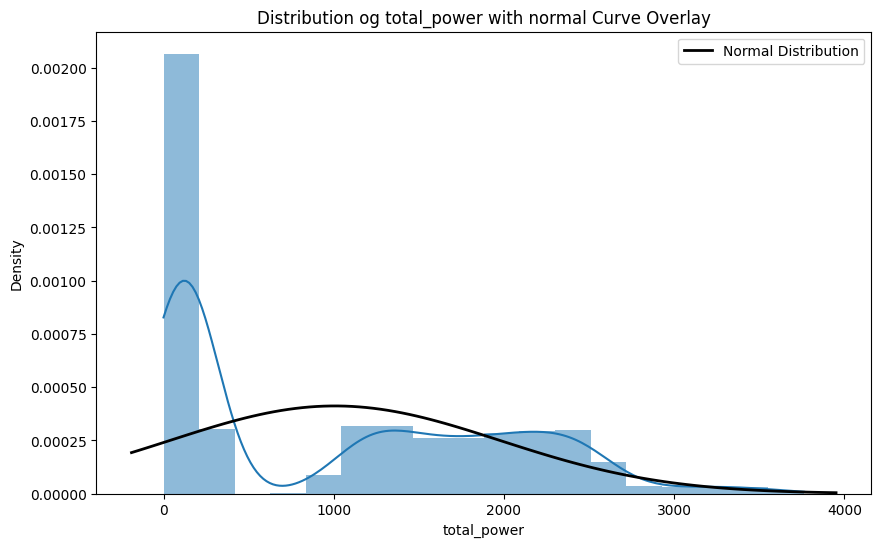

In [25]:
from scipy import stats
plt.figure(figsize=(10,6))
sns.histplot(df[target_col],kde = True, stat="density",linewidth=0)
#Overlay the normal distribution for comparision

xmin,xmax = plt.xlim()
x = np.linspace(xmin,xmax,100)
p = stats.norm.pdf(x, df[target_col].mean(),df[target_col].std())
plt.plot(x,p,'k',linewidth = 2,label = 'Normal Distribution')
plt.title(f'Distribution og {target_col} with normal Curve Overlay')
plt.legend()
plt.show()

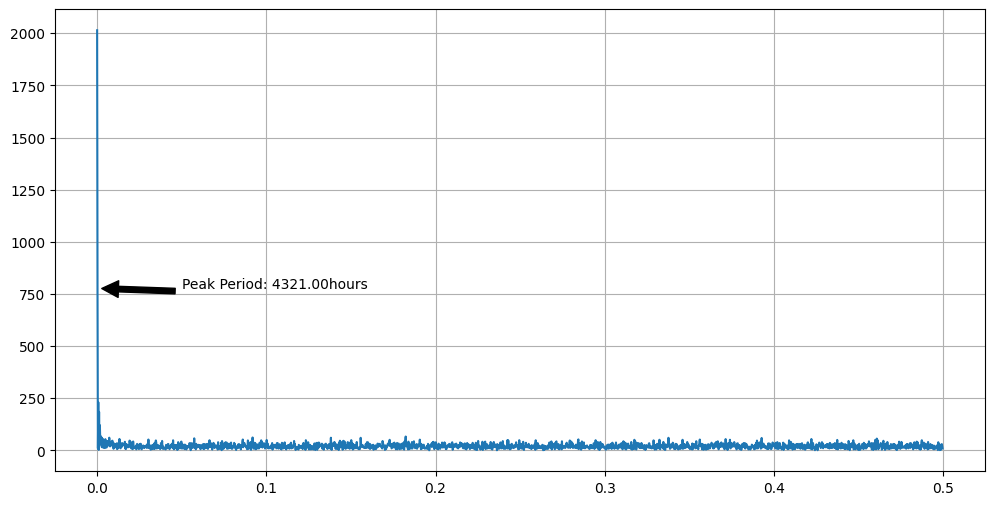

array([0.00000000e+00, 2.31427910e-04, 4.62855820e-04, ...,
       4.99190002e-01, 4.99421430e-01, 4.99652858e-01])

In [49]:
from scipy.fft import fft,fftfreq

y = df[target_col].values
N = len(y)
# T = 1.0/24.0


yf = fft(y)
xf = fftfreq(N,1)

xf_pos = xf[:N//2]
yf_pos = 2.0/N * np.abs(yf[0:N//2])

plt.figure(figsize = (12,6))
plt.plot(xf_pos,yf_pos)

plt.grid(True)

peak_idx = np.argmax( yf_pos[1:]) + 1
peak_freq = xf_pos[peak_idx]

period = 1/peak_freq
plt.annotate(f'Peak Period: {period:.2f}hours',
             xy = (peak_freq, yf_pos[peak_idx]),
            xytext = (peak_freq+0.05, yf_pos[peak_idx]),
    arrowprops=dict(facecolor='black',shrink=0.05))
plt.show()
xf_pos